In [ ]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

In [ ]:
# imports

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
#plt.style.use('seaborn-bright')
import torch
import torch.nn as nn
from pyDOE import *
from scipy.integrate import odeint
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.__version__

cuda


'1.12.1+cu113'

In [ ]:
torch.manual_seed(31)
np.random.seed(31)

In [ ]:
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP,self).__init__()
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        
    
        'Xavier Normal Initialization'
        
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
           
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
       
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](x)
                        
            x = self.activation(z)
            
        x = self.linears[-1](x)
        #print(x)
        
        return x

    
    def loss_bc_init(self,x,y):
      loss_u = self.loss_function(self.forward(x), y)
      return loss_u

    def loss_initernal(self, x_train):
      x_train.requires_grad = True
      p = self.forward(x_train)
      u_g = gradients(p, x_train)[0]
      u_x, u_y, u_t= u_g[:, [0]], u_g[:,[1]] , u_g[:,[2]]
      u_xx = gradients(u_x, x_train)[0][:, [0]]
      u_yy = gradients(u_y, x_train)[0][:, [1]]
      
      pde = u_t - D*(u_xx + u_yy)
      loss_pde = pde.pow(2).mean()
      return loss_pde

    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_bc_init(init_cond_train,u_init_cond_train)
        loss_f = self.loss_initernal(f_train)
        
        loss_val = loss_u + loss_f
        
        return loss_val

In [ ]:
def gradients(outputs, inputs):
     return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def nptoTensor(data):
     return torch.from_numpy(data).to(device).float()
def u_2d(x_2d):
  return np.zeros((30*30))

In [ ]:
def trainingdata(Nx,Ny,Nt,Nf,Nu):
    x = np.linspace(0,1,Nx)
    y = np.linspace(0,1,Ny)
    t = np.linspace(0,1,Nt)
    X, Y = np.meshgrid(x,y)

    x_2d = np.concatenate((X.flatten()[:,None], Y.flatten()[:,None]), axis=1)
    t_2d = np.zeros((Nx*Ny,1))
    intial_condition = np.concatenate((x_2d,t_2d), axis = 1)
       
    u_inital = u_2d(x_2d)[:,None]
    


    lower_x = np.concatenate((X[:,0][:,None], Y[:,0][:,None]), axis = 1)
    upper_x = np.concatenate((X[:,-1][:,None], Y[:,0][:,None]), axis = 1)
    right_y = np.concatenate((X[0,:][:,None], Y[-1,:][:,None]), axis = 1)
    left_y = np.concatenate((X[0,:][:,None], Y[0,:][:,None]), axis = 1)
    x_bound = np.vstack([lower_x , upper_x , right_y , left_y])
    
    x_bound_ext = np.tile(x_bound, [Nt, 1])
    t_bound_ext = np.tile(t[:,None], [Nx*4, 1])
    xt_bound_ext = np.concatenate((x_bound_ext, t_bound_ext), axis=1)
    u_bound_ext =  np.zeros((Nx*4*Nt))[:,None]
    i = 0
    for x in xt_bound_ext:
      if(x[0]==1):
        u_bound_ext[i]=10.0
      i+=1  
   
    
    

    all_Init_bcs = np.vstack([intial_condition, xt_bound_ext])
    all_u_init_bcs = np.vstack([u_inital, u_bound_ext])
    

    #idx = np.random.choice(all_Init_bcs.shape[0],Nu, replace=False)
    ldx = np.random.permutation(all_Init_bcs.shape[0])

    all_Init_bcs = all_Init_bcs[ldx]
    all_u_init_bcs = all_u_init_bcs[ldx]
    
    f_train = lhs(3,Nf)
    f_train = np.vstack((f_train, all_Init_bcs))

    return all_Init_bcs , all_u_init_bcs , f_train

In [ ]:
N_u = 500 # Random point
N_x = 30 #Total number of data points for 'x'
N_y = 30 #Total number of data points for 'y'
N_t = 50 #Total number of data points for 't'
N_f = 10000 #Total number of collocation points 
init_cond_train_np_array, u_init_cond_train_np_array, f_train_np_array = trainingdata(N_x,N_y,N_t,N_f, N_u)

In [ ]:
init_cond_train = nptoTensor(init_cond_train_np_array)
u_init_cond_train = nptoTensor(u_init_cond_train_np_array)
f_train = nptoTensor(f_train_np_array)
D = .1
neurons = 50
#neurons1 = 25
#neurons2 = 28
layers = np.array([3,neurons,neurons,neurons,neurons,neurons,neurons,neurons,neurons,neurons,neurons,neurons,neurons,neurons,1])
#layers = np.array([3,300,150,75,60,32,32,1])
mlp = MLP(layers).to(device)

In [ ]:
step_size = 10000
gamma = .1
A_hist = []
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
max_iter = 16600

tic = time.time()

for i in range(max_iter):

     loss = mlp.loss(init_cond_train, u_init_cond_train, f_train)
     A_hist.append([i,loss]) 
     loss.backward() #backprop
     optimizer.step()
     optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
     
     if (i+1) % 1000 == 0:
          print("Epoch: {}, MSE: {:.6f}".format((i+1), loss))

toc = time.time()
print(f'total training time in minutes: {(toc-tic)/60}')

Epoch: 1000, MSE: 2.969940
Epoch: 2000, MSE: 2.483031
Epoch: 3000, MSE: 2.282949
Epoch: 4000, MSE: 1.736132
Epoch: 5000, MSE: 1.889315
Epoch: 6000, MSE: 1.483846
Epoch: 7000, MSE: 1.414173
Epoch: 8000, MSE: 1.341031
Epoch: 9000, MSE: 1.327365
Epoch: 10000, MSE: 1.245552
Epoch: 11000, MSE: 2.075293
Epoch: 12000, MSE: 1.302027
Epoch: 13000, MSE: 1.126312
Epoch: 14000, MSE: 1.094352
Epoch: 15000, MSE: 1.131482
Epoch: 16000, MSE: 1.054041
total training time in minutes: 13.839010361830393


In [ ]:
A_hist_list = {'epoch':[],
               'mse':[]}
for i in A_hist:
  A_hist_list['epoch'].append(i[0])
  #print((i[1].item()))
  A_hist_list['mse'].append(i[1].item())

In [ ]:
import pandas as pd
loss_df = pd.DataFrame.from_dict(A_hist_list)
import plotly.express as px
px.line(loss_df['mse']).show()

In [ ]:
path = '2-Diffusion_PDE4.pth'
torch.save(mlp.state_dict(), path)

In [ ]:
path = '/content/2-Diffusion_PDE4.pth'
mlp.load_state_dict(torch.load(path))
mlp.eval()

MLP(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): Linear(in_features=50, out_features=50, bias=True)
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [ ]:
model = MLP(layers)
state_dict = torch.load(path)
model.load_state_dict(state_dict)
model.eval()
example = torch.rand([1,3])

# run the tracing
traced_script_module = torch.jit.trace(model, example)
# save the converted model
#traced_script_module.save("Diffusion_PDE.pt")
torch.jit.save(traced_script_module,"2D-Diffusion_PDE.pt")
loaded = torch.jit.load("2D-Diffusion_PDE.pt")

In [ ]:
def build_mesh(N, t):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    _t = np.array([t])
    m = np.meshgrid(x,y, _t)
    m = np.stack(m, -1).reshape(-1, 3)
    #m = (m - lb)/(ub - lb)
    return x, y, m

def build_mesh1(N, t):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    _t = np.array([t])
    x,y,t = np.meshgrid(x,y, _t)
n = 30
t = 0

In [ ]:
def central_difference():
    return u[n][i][j] + delta_t*(alpha * (u[n][i+1][j] +u[n][i-1][j] + u[n][i][j+1] + u[n][i][j-1] - 4*u[n][i][j])/(delta_x)**2)

def initial(x,y):
  x = x[1:-1]
  y = y[1:-1]
  x,y = np.meshgrid(x,y)
  return 0
  # return np.sin(np.pi*x)*np.sin(np.pi*y)

points_in_x = 30
points_in_y = 30
alpha = .1

x =np.linspace(0,1,points_in_x)
delta_x = x[1] - x[0]

y =np.linspace(0,1,points_in_x)
delta_y = y[1] - y[0]


delta_t = 0.5*(delta_x**2*delta_y**2)/((delta_x**2 + delta_y**2)*alpha)
#delta_t = .02
points_in_t = 1./delta_t
points_in_t = int(points_in_t)

t = np.linspace(0,1,points_in_t)

u = np.zeros((len(t), len(x), len(y)))

u[: , 0,:] = 0                         # left boundary
u[: , len(x)-1,:] = 0
u[:,:,0] = 0
u[:,:,len(y)-1] = 0
u[0,1:len(x)-1,1:len(y)-1] = initial(x,y) 



for n in range(0 , len(t)-1):
    for i in range(1 , len(x)-1):
        for j in range(1,len(y)-1):
            u[n+1][i][j] = central_difference()

In [ ]:
import numpy as np
n = 30
def build_mesh(N, t):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    _t = np.array([t])
    m = np.meshgrid(x,y, _t)
    m = np.stack(m, -1).reshape(-1, 3)
    
    return x, y, m

def build_mesh1(N, t):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    _t = np.array([t])
    x,y,t = np.meshgrid(x,y, _t)
    return x, y, t

x1, y1, m1 = build_mesh(n, 0)
x2, y2, m2 = build_mesh(n, .25)
x3, y3, m3 = build_mesh(n, .5)
x4, y4, m4 = build_mesh(n, .75)
x5, y5, m5 = build_mesh(n, 1)

xe1, ye1, te1 = build_mesh1(n, 0)
xe2, ye2, te2 = build_mesh1(n, .25)
xe3, ye3, te3 = build_mesh1(n, .5)
xe4, ye4, te4 = build_mesh1(n, .75)
xe5, ye5, te5 = build_mesh1(n, 1)

In [ ]:
def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return np.abs(p)

p1 = eval_model(m1)
p2 = eval_model(m2)
p3 = eval_model(m3)
p4 = eval_model(m4)
p5= eval_model(m5)

In [ ]:
def plot_model(x, y,p,x1,y1,t,u_fdm,title):
    pe = np.sin(np.pi*y1)*np.sin(np.pi*x1)*np.exp((-.1*t)*(2*np.pi**2))
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    # img1 = ax.contour(x,y,pe.reshape(-1,n),linewidths=5,levels=np.linspace(0, 1, 10),colors='k', linestyles='solid')
    #plt.clabel(img, inline=2, fontsize=20)
    # img2 = ax.contour(x,y,u_fdm.reshape(-1,n),linewidths=5,levels=np.linspace(0, 1, 10),colors='green', linestyles='loosely dotted')
    #plt.clabel(img, inline=1, fontsize=5)
    # img3 = ax.contour(x,y,p.reshape(-1,n),linewidths=5,levels=np.linspace(0, 1, 10),colors='red', linestyles='dotted')
    img4 =ax.contourf(x, y, p.reshape(-1,n),cmap="rainbow")
    fig.colorbar(img4)
    #plt.clabel(img3, inline=1, fontsize=20)
    
    



    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    # Show the minor grid lines with very faint and almost transparent grey lines
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
    
    ax.set_xlabel('x', labelpad=10)
    ax.set_ylabel('y', labelpad=10)
    ax.set_title(title, fontsize=15)
    #h1,_ = img1.legend_elements()
    #h2,_ = img2.legend_elements()
    #h3,_ = img3.legend_elements()
    #ax.legend([h1[0], h2[0]], ['Contour 1', 'Contour 2'])
   
           
    #ax.legend([h1[0], h2[0], h3[0]], ['Exact', 'FDM', 'NN'],loc='upper center', bbox_to_anchor=(0.5, -0.2),frameon=False, shadow=False, ncol=3, fontsize=22)
    #l2 = np.sqrt(np.sum((pe.reshape(-1,n)-p.reshape(-1,n))**2))/(np.sqrt(np.sum(pe.reshape(-1,n))**2))
    #l2_fdm = np.sqrt(np.sum((pe.reshape(-1,n)-u_fdm.reshape(-1,n))**2))/(np.sqrt(np.sum(pe.reshape(-1,n))**2))
    #print('l2_NN',l2,'l2_fdm',l2_fdm)
    #plt.title(f"t = {t:.3f} (L2_NN = {l2:.7f}) (L2_FDM = {l2_fdm:.7f})")
    #plt.savefig(f"t = str(t).png", dpi=600, transparent=False, bbox_inches='tight')
    #plt.show()

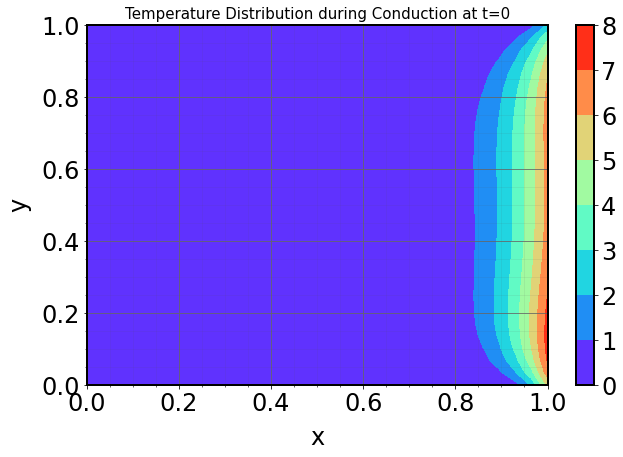

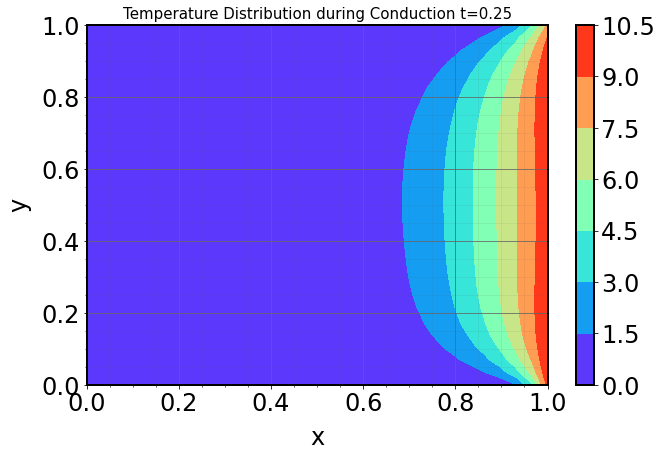

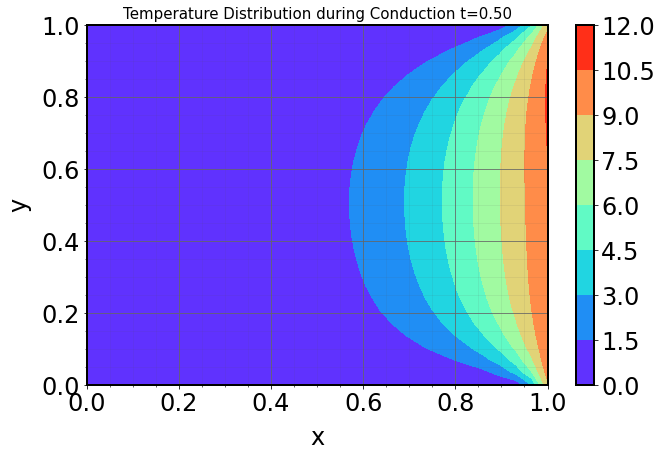

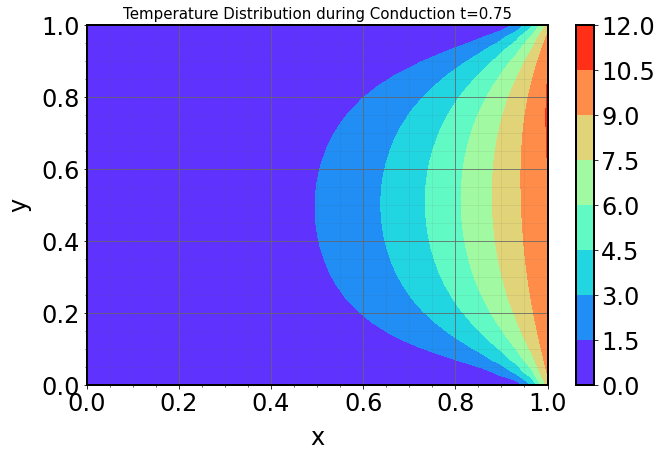

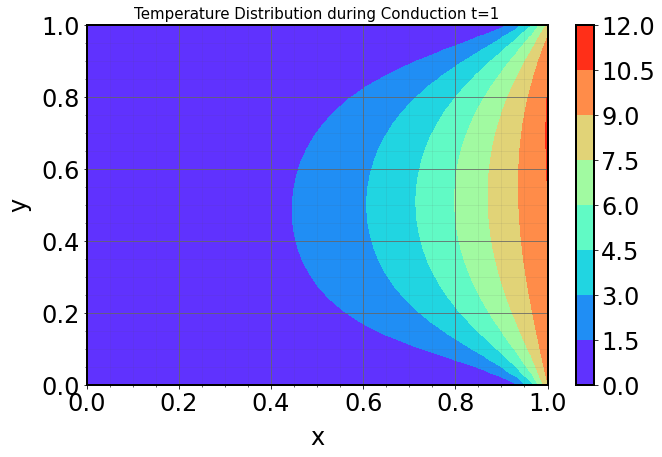

In [ ]:
plot_model(x1,y1, p1, xe1, ye1, te1, u[0,:],'Temperature Distribution during Conduction at t=0')
plot_model(x2,y2, p2, xe2, ye2, te2, u[35,:],'Temperature Distribution during Conduction t=0.25')
plot_model(x3,y3, p3, xe3, ye3, te3, u[71,:],'Temperature Distribution during Conduction t=0.50')
plot_model(x4,y4, p4, xe4, ye4, te4, u[107,:], 'Temperature Distribution during Conduction t=0.75')
plot_model(x5,y5, p5, xe5, ye5, te5, u[-1,:], 'Temperature Distribution during Conduction t=1')